In [1]:
from init_plot import *

/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-08 12:34:16.580932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



-------------------------help-------------------------
> parameter
    p_root	[name] res_publish
        p_run, p_plot, p_res, p_cache, p_pdf
    p_df_varmap
    map_sp_reverse
    rng
> run
    run_cross_species_models
    h5ad_to_mtx
    load_adata
    get_path_varmap
    find_path_from_para
    load_normalized_adata

> res
    get_test_result_df
    get_res_obs
    get_adata_umap
    show_umap

> plot
    get_color_map
    show_color_map
    show_color
    plot_umap
    savefig



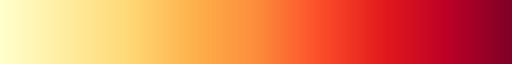

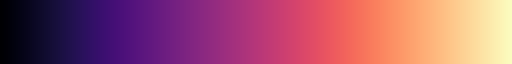

In [2]:
item = 'healthy'
show_legend = False

model = 'csMAHN'
if sys.argv[1] == 'True':
    model = sys.argv[2]
assert model in 'Seurat,came,csMAHN,SAMap'.split(
    ','), '[Error] Invalid modle "{}"'.format(model)

display(cm,cm_2)

# pdf

healthy 存在多个部分

需要分开绘图

先将fig绘制出来，在最后创建PdfPages进行保存

## HCL and MCA

In [4]:
# HCL_MCA
_q_tissue = 'Adrenal-Gland,Bone-Marrow,Brain,\
Heart,Intestine,Kidney,Liver,Spleen'.split(',')
df = get_test_result_df(p_res).query("tissue in @_q_tissue")
df = df[df['name'].str\
    .extract(';(\\d{6}-\\d{4})$', expand=False)\
    .fillna('').str.len() == 0]
df['is_1v1'] = ''
df['is_1v1'] = df['is_1v1'].mask(
    df['resdir_tag'].str.contains('is_1v1=True'), '_1v1').mask(
        df['model'] == 'Seurat', '')
df['model_mask'] = df.apply(lambda _: '{model}{is_1v1}'\
                                        .format(**_), axis=1)
df = df[~df['model_mask'].str.endswith('_1v1')]
df['tissue_mask'] = df['tissue'].str.replace('-', '\n')

df['F1-score'] = df.apply(get_res_stat,key='F1-score',
                                      q="dataset_type == 'que'",axis=1)
df['Accuracy'] = df.apply(get_res_stat,key='Accuracy',
                                      q="dataset_type == 'que'",axis=1)
df
_temp = df.apply(
    lambda row: '{tissue};{sp_ref}{sp_que};{model_mask}'.format(
        **row), axis=1)
assert _temp.is_unique, '[isnot unique]'
df.index = _temp
del _temp

df['item'] = 'HCL_MCA'
display(df.head(2))
del _q_tissue


[extract]
^(?P<tissue>.+)_(?P<sp_ref>.+)-corss-(?P<sp_que>.+);(?P<model>came|csMAHN|Seurat|SAMap);(?P<name_ref>[\w-]+)-map-(?P<name_que>[[\w-]+);?(?P<resdir_tag>.+)?$


/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/pandas/core/strings/accessor.py:2738: FutureWarning: Possible nested set at position 127
  regex = re.compile(pat, flags=flags)


,dir,name,tissue,sp_ref,sp_que,model,name_ref,name_que,resdir_tag,is_1v1,model_mask,tissue_mask,F1-score,Accuracy,item
Brain;mh;SAMap,/public/workspace/licanchengup/link/res_publis...,Brain_m-corss-h;SAMap;m_bra-map-h_bra;is_1v1=F...,Brain,m,h,SAMap,m_bra,h_bra,is_1v1=False,,SAMap,Brain,0.896573,0.894788,HCL_MCA
Brain;mh;csMAHN,/public/workspace/licanchengup/link/res_publis...,Brain_m-corss-h;csMAHN;m_bra-map-h_bra;epochs=...,Brain,m,h,csMAHN,m_bra,h_bra,epochs=500;is_1v1=False,,csMAHN,Brain,0.932329,0.932512,HCL_MCA


In [5]:
ppara_key = 'F1-score'
ppara_data = {}
_plot = df.query("sp_ref == 'h'")\
    .loc[:, 'tissue_mask,model_mask'.split(',')+['Accuracy','F1-score']]\
    .sort_values('tissue_mask,model_mask'.split(',')).copy()
_plot['x'] = _plot['tissue_mask'].map({_: i*4
    for i, (_) in enumerate(_plot['tissue_mask'].unique())})
ppara_data.update({'HCL_MCA_h':_plot})
_plot = df.query("sp_ref == 'm'")\
    .loc[:, 'tissue_mask,model_mask'.split(',')+['Accuracy','F1-score']]\
    .sort_values('tissue_mask,model_mask'.split(',')).copy()
_plot['x'] = _plot['tissue_mask'].map({_: i*4
    for i, (_) in enumerate(_plot['tissue_mask'].unique())})
ppara_data.update({'HCL_MCA_m':_plot})
del _plot,df

ppara_color_map = {
    'HCL_MCA_model_mask':get_color_map('Seurat,SAMap,came,csMAHN'.split(','))
}

In [6]:

ppara_map_plot_function_custom = {}
def _func(df_plot,key,ax):
    for model_mask,marker in zip('Seurat,SAMap,came,csMAHN'.split(','),
                         '.,h,p,v'.split(',')):
        _plot = df_plot.query("model_mask == '{}'".format(model_mask))
        ax.scatter(_plot['x'], _plot[key], label=model_mask,s=20,
                   marker=marker,color=ppara_color_map['HCL_MCA_model_mask'][model_mask])
    ax.set_yticks(np.linspace(0, 1, 6), ['{:.1f}'.format(_) 
        for _ in np.linspace(0, 1, 6)],**fontdict_default)
    ax.set_xticks(
        df_plot.drop_duplicates('tissue_mask,x'.split(','))['x'],
        df_plot.drop_duplicates('tissue_mask,x'.split(','))['tissue_mask'],
        **fontdict_default
    )
    ax.set_ylabel( 'weighted {}'.format(key) if key== 'F1-score' else key,
                 fontdict = fontdict_default)

ppara_map_plot_function_custom.update({'scatter_model':_func})
del _func
print(*ppara_map_plot_function_custom.keys(),sep='\n')

scatter_model


### plot

Text(0.5, 1.0, 'model')

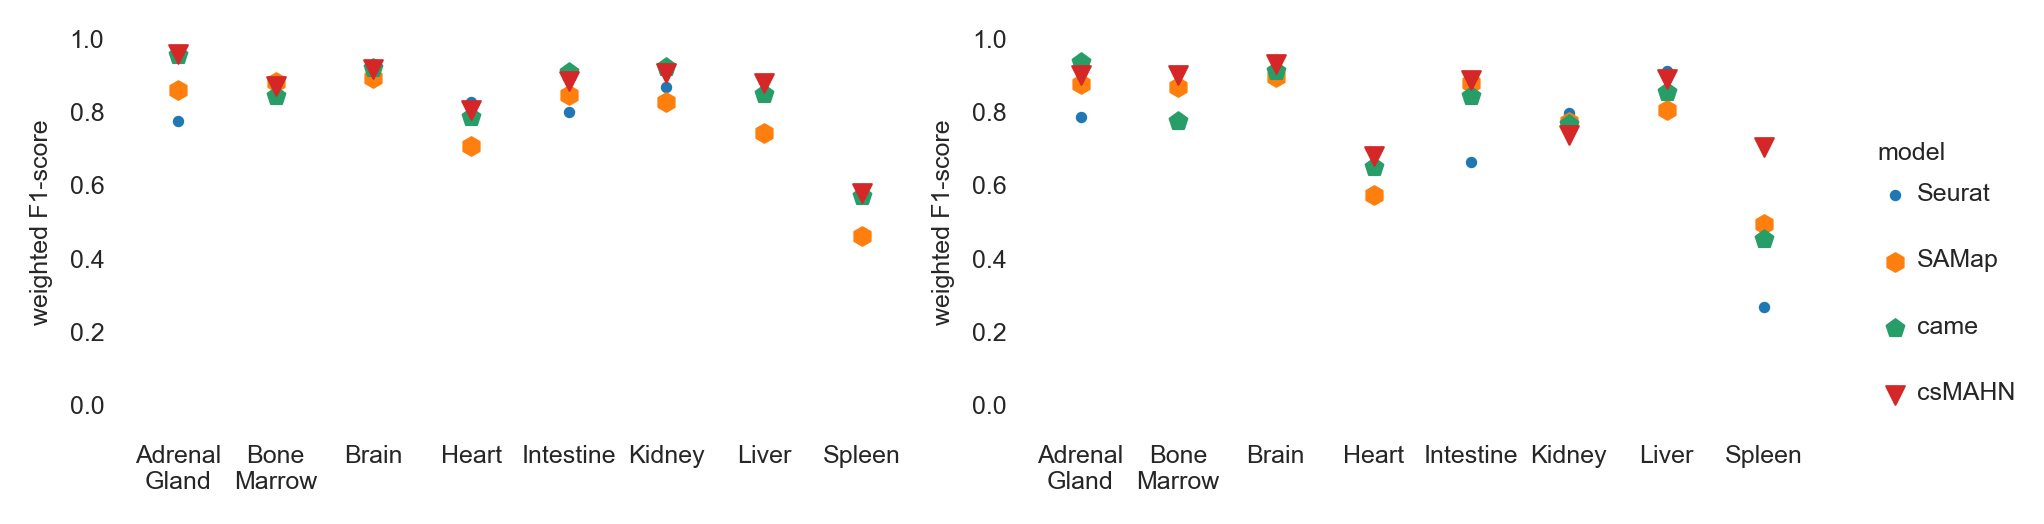

In [7]:
fig = plt.figure(figsize=(8.27, 11.69))
spec = fig.add_gridspec(nrows=46, ncols=32,
                    left=0.03, right=1,  # 设置边距
                    bottom=0.02, top=0.98,  # 设置边距
                    wspace=0, hspace=0)  # 设置子图间距

ax = plt_pdf_add_ax_with_spec(fig,spec,2,1,10,5)
ppara_map_plot_function_custom['scatter_model'](ppara_data['HCL_MCA_h'],ppara_key,ax)
ax = plt_pdf_add_ax_with_spec(fig,spec,14,1,10,5)
ppara_map_plot_function_custom['scatter_model'](ppara_data['HCL_MCA_m'],ppara_key,ax)

ax = plt_pdf_add_ax_with_spec(fig,spec,25,3,1,3)
show_color_map(ppara_color_map['HCL_MCA_model_mask'],ax=ax,
               size=20,marker= '.,h,p,v'.split(','),fontdict=fontdict_default)
ax.set_title('model',fontdict=fontdict_default)

## retina

In [8]:
_df = get_test_result_df(p_res)
_df = _df.query("tissue == 'retina'")
_df['is_1v1'] = ''
_df['is_1v1'] = _df['is_1v1'].mask(
    _df['resdir_tag'].str.contains('is_1v1=True'), '_1v1').mask(
        _df['model'] == 'Seurat', '')
_df['model_mask'] = _df.apply(lambda _: '{model}{is_1v1}'.format(
        **_), axis=1)
_df['F1-score'] = _df.apply(get_res_stat,key='F1-score',q="dataset_type == 'que'",
                          axis=1)
_df['Accuracy'] = _df.apply(get_res_stat,key='Accuracy',q="dataset_type == 'que'",
    axis=1)

_df['time_tag'] = _df['name'].str.extract(
    ';(\\d{6}-\\d{4})$', expand=False).fillna('')
_df = _df[_df['time_tag'].str.len() == 0]
_df = _df.drop(columns=['time_tag'])

_df['parameter_hvg_deg'] = _df['resdir_tag'].str.extract(
    '(n_hvgs=\\d+;n_degs=\\d+)', expand=False).fillna('')
_df = _df[_df['parameter_hvg_deg'].str.len() == 0]


_temp = _df.apply(
    lambda row: '{tissue};{sp_ref}{sp_que};{model_mask}'.format(
        **row), axis=1)
assert _temp.is_unique, '[isnot unique]'
_df.index = _temp
del _temp

# _df.head(2)

_key = 'Accuracy'
_plot = _df.pivot(values=_key,index='model_mask',columns='sp_que')
ppara_data.update({'retina_{}'.format(_key):_plot.rename(columns=map_sp)})
_key = 'F1-score'
_plot = _df.pivot(values=_key,index='model_mask',columns='sp_que')
ppara_data.update({'retina_{}'.format(_key):_plot.rename(columns=map_sp)})
del _df,_key,_plot
print('\n> ppara_data-------------------------',
      *ppara_data.keys(),sep='\n')
ppara_color_map.update({
    'retina_model':get_colors_article('SAMap,came,csMAHN'\
                                .split(','), 1)})

print('\n>ppara_color_map-------------------------',
      *ppara_color_map.keys(),sep='\n')


[extract]
^(?P<tissue>.+)_(?P<sp_ref>.+)-corss-(?P<sp_que>.+);(?P<model>came|csMAHN|Seurat|SAMap);(?P<name_ref>[\w-]+)-map-(?P<name_que>[[\w-]+);?(?P<resdir_tag>.+)?$

> ppara_data-------------------------
HCL_MCA_h
HCL_MCA_m
retina_Accuracy
retina_F1-score

>ppara_color_map-------------------------
HCL_MCA_model_mask
retina_model


In [9]:
def _func(_plot,key,ax,color_map,del_ytick=False):
    # line of Seurat
    ax.hlines(_plot['Seurat'], 0.6, 2.4, linestyles=':',linewidth=1,
              colors='black')
    ax.text(.8,_plot['Seurat'] - .1, 'Seurat',fontdict=fontdict_default)
    ax.set_title(_plot.name)
    for k, v in color_map.items():
        ax.plot([1, 2], [_plot['{}_1v1'.format(k)], _plot[k]],
            label=k, color=v, marker='.')
    
    ax.set_xlim(0.5, 2.5)
    ax.set_ylim(0, 1.1)
    ax.set_xticks([1, 2], 'one\nto one,append many\nand one\nto many'.split(','),**fontdict_default)
    if del_ytick:
        ax.set_yticks([], [])
    else:
        ax.set_yticks(np.linspace(0, 1, 6), ['{:.1f}'.format(_)
            for _ in np.linspace(0, 1, 6)],**fontdict_default)
        ax.set_ylabel( 'weighted {}'.format(key) if key== 'F1-score' else key,
                 fontdict = fontdict_default)
    ax.tick_params('y',which='both',length=2)
    ax.tick_params('x',which='both',length=1)
    
ppara_map_plot_function_custom.update({'retina_line_one2one':_func})
del _func
print(*ppara_map_plot_function_custom.keys(),sep='\n')

scatter_model
retina_line_one2one


### plot

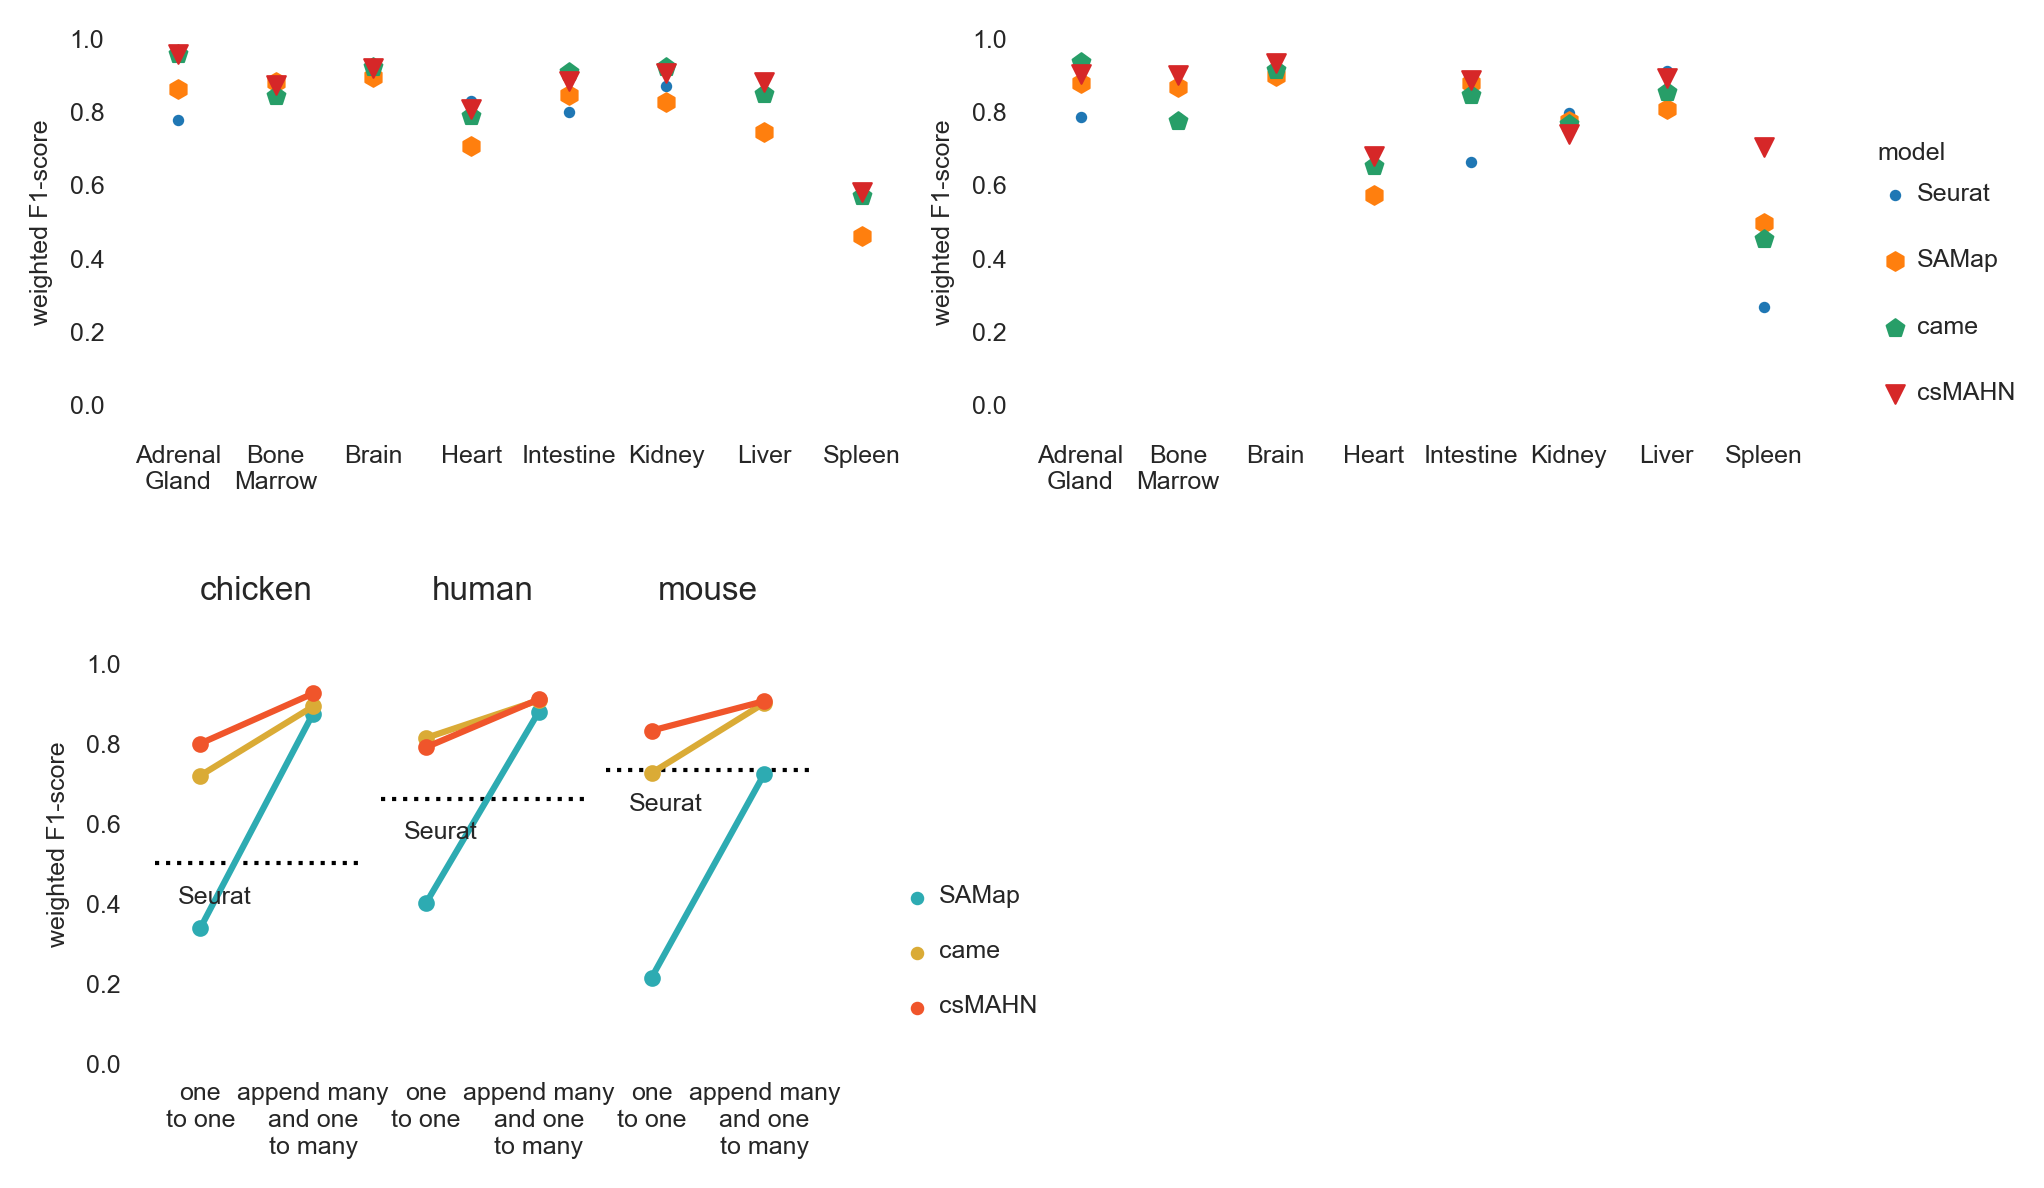

In [10]:

for _i,((_,_plot)) in enumerate(ppara_data['retina_{}'.format(ppara_key)].items()):
    ax = plt_pdf_add_ax_with_spec(fig,spec,2+_i*3,9,3,6)
    ppara_map_plot_function_custom['retina_line_one2one'](_plot,
        ppara_key,ax,ppara_color_map['retina_model'],del_ytick= _i > 0
    )

ax = plt_pdf_add_ax_with_spec(fig,spec,12,12,1,3)
show_color_map(ppara_color_map['retina_model'],ax=ax,
               size=30,fontdict=fontdict_default)
ax.set_ymargin(.5)
fig

## retina-p

In [11]:
_df = get_test_result_df(p_res)
_df = _df.query("tissue == 'retina-p'").query("sp_ref == 'z'")
_df['is_1v1'] = ''
_df['is_1v1'] = _df['is_1v1'].mask(
    _df['resdir_tag'].str.contains('is_1v1=True'), '_1v1').mask(
        _df['model'] == 'Seurat', '')
_df['model_mask'] = _df.apply(lambda _: '{model}{is_1v1}'.format(
        **_), axis=1)
_df['F1-score'] = _df.apply(get_res_stat,key='F1-score',q="dataset_type == 'que'",
                          axis=1)
_df['Accuracy'] = _df.apply(get_res_stat,
                            key='Accuracy',q="dataset_type == 'que'",
    axis=1)

_df['time_tag'] = _df['name'].str.extract(
    ';(\\d{6}-\\d{4})$', expand=False).fillna('')
_df = _df[_df['time_tag'].str.len() == 0]
_df = _df.drop(columns=['time_tag'])


# Seurat
ppara_data.update(
{'retina-p_Seurat_Accuracy':{map_sp[_row['sp_que']]:_row['Accuracy'] 
             for _i,_row in  _df.query("model =='Seurat'").iterrows()},
'retina-p_Seurat_F1-score':{map_sp[_row['sp_que']]:_row['F1-score']
                for _i,_row in  _df.query("model =='Seurat'").iterrows()}}    
)

_df['parameter_hvg_deg'] = _df['resdir_tag'].str.extract(
    '(n_hvgs=\\d+;n_degs=\\d+)', expand=False).fillna('')
_df['parameter_nfeats_hidden'] = _df['resdir_tag'].str.extract(
    '(nfeats=\\d+;hidden=\\d+)', expand=False).fillna('')

_df_item = _df[_df['parameter_hvg_deg'].str.len() > 0]
_temp = _df_item.apply(
    lambda row: '{tissue};{sp_ref}{sp_que};{model_mask};{parameter_hvg_deg}'.format(
        **row), axis=1)
assert _temp.is_unique, '[isnot unique]'
_df_item.index = _temp
del _temp
# _df_item = _df_item.pivot(
#     index='parameter_hvg_deg',
#     columns='sp_que',
#     values='Accuracy')
# _df_item.columns = _df_item.columns.map(map_sp)
# ppara_data.update({'retina-p_hvg_deg_Accuracy':_df_item})
_df_item = _df_item.pivot(
    index='parameter_hvg_deg',
    columns='sp_que',
    values='F1-score')
_df_item.columns = _df_item.columns.map(map_sp)
ppara_data.update({'retina-p_hvg_deg_F1-score':_df_item})


_df_item = _df[_df['parameter_nfeats_hidden'].str.len() > 0]
_temp = _df_item.apply(
    lambda row: '{tissue};{sp_ref}{sp_que};{model_mask};{parameter_nfeats_hidden}'.format(
        **row), axis=1)
assert _temp.is_unique, '[isnot unique]'
_df_item.index = _temp
del _temp
_df_item = _df_item.pivot(
    index='parameter_nfeats_hidden',
    columns='sp_que',
    values='F1-score')
_df_item.columns = _df_item.columns.map(map_sp)
ppara_data.update({'retina-p_nfeats_hidden_F1-score':_df_item})

ppara_color_map.update({'retina-p_sp_que': get_colors_article(_df_item.columns, 0)})

# _df.head(2)


[extract]
^(?P<tissue>.+)_(?P<sp_ref>.+)-corss-(?P<sp_que>.+);(?P<model>came|csMAHN|Seurat|SAMap);(?P<name_ref>[\w-]+)-map-(?P<name_que>[[\w-]+);?(?P<resdir_tag>.+)?$


### overlook

In [12]:
for _ in 'retina-p_hvg_deg_F1-score,retina-p_nfeats_hidden_F1-score'.split(','):
    print('[has nan] [{}] {}'.format(ppara_data[_].isna().any().any(),_))

[has nan] [False] retina-p_hvg_deg_F1-score
[has nan] [False] retina-p_nfeats_hidden_F1-score


In [13]:
print('\n> ppara_data-------------------------',
      *ppara_data.keys(),sep='\n')
print('\n>ppara_color_map-------------------------',
      *ppara_color_map.keys(),sep='\n')

display(
    ppara_data['retina-p_hvg_deg_F1-score'].style.highlight_null()\
    .background_gradient(cmap=cm, vmin=.5, vmax=.9),
    ppara_data['retina-p_nfeats_hidden_F1-score'].style.highlight_null()\
    .background_gradient(cmap=cm, vmin=.5, vmax=.9)
)
print('[note] boxplot 以.8填充了nan')
ppara_data['retina-p_hvg_deg_F1-score'] = ppara_data['retina-p_hvg_deg_F1-score'].fillna(0.8)
ppara_data['retina-p_nfeats_hidden_F1-score'] = ppara_data['retina-p_nfeats_hidden_F1-score'].fillna(0.8)


> ppara_data-------------------------
HCL_MCA_h
HCL_MCA_m
retina_Accuracy
retina_F1-score
retina-p_Seurat_Accuracy
retina-p_Seurat_F1-score
retina-p_hvg_deg_F1-score
retina-p_nfeats_hidden_F1-score

>ppara_color_map-------------------------
HCL_MCA_model_mask
retina_model
retina-p_sp_que


sp_que,chicken,human,mouse
parameter_hvg_deg,,,
n_hvgs=1000;n_degs=100,0.928917,0.926899,0.855093
n_hvgs=1000;n_degs=50,0.877305,0.896133,0.916034
n_hvgs=2000;n_degs=100,0.916014,0.961013,0.913441
n_hvgs=2000;n_degs=50,0.927372,0.925079,0.900346
n_hvgs=3000;n_degs=100,0.941165,0.948866,0.941811
n_hvgs=3000;n_degs=50,0.857842,0.874950,0.914383


sp_que,chicken,human,mouse
parameter_nfeats_hidden,,,
nfeats=128;hidden=64,0.860349,0.910920,0.932434
nfeats=32;hidden=64,0.872825,0.881373,0.891891
nfeats=64;hidden=128,0.907731,0.952881,0.898121
nfeats=64;hidden=32,0.881438,0.910436,0.848776
nfeats=64;hidden=64,0.897320,0.954130,0.899008


[note] boxplot 以.8填充了nan


In [14]:
def _func(df_plot,  key, color_map, dict_Seurat,ax):
    _l2d_style = {'color':'grey','alpha':.5}
    ax.boxplot(
        df_plot.to_numpy(),
        positions=np.arange(3),
        boxprops=_l2d_style,capprops= _l2d_style,
        whiskerprops=_l2d_style,
        widths=.55,sym='.'
    )
    for _i, (_sp_que) in enumerate(df_plot.columns):
        ax.scatter(
            np.repeat(_i, df_plot[_sp_que].size) + (rng.random(size=df_plot[_sp_que].size) - 0.5)/3,
            df_plot[_sp_que], color=color_map[_sp_que],
            s=5)
        #Seurat
        ax.scatter(_i,dict_Seurat[_sp_que], s=10, marker='D', color='#9C9C9C')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6), ['{:.1f}'.format(_) 
        for _ in np.linspace(0, 1, 6)],**fontdict_default)
    ax.set_ylabel('weighted {}'.format(key) if key == 'F1-score' else key,
                  **fontdict_default)
    ax.set_xticks(np.arange(3), df_plot.columns,**fontdict_default)

ppara_map_plot_function_custom.update({'retina-p_box_scatter':_func})
del _func
print(*ppara_map_plot_function_custom.keys(),sep='\n')


scatter_model
retina_line_one2one
retina-p_box_scatter


### plot

In [15]:
ax = plt_pdf_add_ax_with_spec(fig,spec,16,9,5,6)
ppara_map_plot_function_custom['retina-p_box_scatter'](
    ppara_data['retina-p_hvg_deg_{}'.format(ppara_key)],ppara_key,
    ppara_color_map['retina-p_sp_que'],
    ppara_data['retina-p_Seurat_{}'.format(ppara_key)],ax)
ax.set_title('different hyperparameter\nn_hvgs and n_degs')
ax = plt_pdf_add_ax_with_spec(fig,spec,23,9,5,6)
ppara_map_plot_function_custom['retina-p_box_scatter'](
    ppara_data['retina-p_nfeats_hidden_{}'.format(ppara_key)],ppara_key,
    ppara_color_map['retina-p_sp_que'],
    ppara_data['retina-p_Seurat_{}'.format(ppara_key)],ax)
ax.set_title('different hyperparameter\nnfeats and hidden')
# legend
ax = plt_pdf_add_ax_with_spec(fig,spec,29,13)
show_color_map(
    {'csMAHN': '#9C9C9C', 'Seurat': '#9C9C9C'},
    marker=['o', 'D'], size=10, ax=ax)
ax.set_ymargin(.25)

# save

In [16]:
# text ----------------------------------------
for _text,_x,_y in zip(
    'a,b,c'.split(','),
    [int(_) for _ in '0,0,14'.split(',')],
    [int(_) for _ in '0,8,8'.split(',')]):
    plt_pdf_add_text_with_ax(plt_pdf_add_ax_with_spec(fig,spec,_x,_y),_text)
# note ----------------------------------------
_text = """
(a) csMAHN performed well on weighted-F1 score compared to  Seurat,SAMap and came on
8 tissue of HCL and MCA.human as reference and mouse as query (left). mouse as reference
and human as query (left). (b) Weighted-F1 score of csMHAN is improved after adding the
homology information of one2many and many2many to the model on three pairs of cross-
species scRNA-seq data sets about the retina with zebrafish as the reference and with
chick, mouse, and human as the queries. (c) the performance of csMAHN under different
hyperparameters is stable and robust. exchange hyperparameters,n_hvgs and ndegs (left),
nfeats and hidden (right).
"""
ax = plt_pdf_add_ax_with_spec(fig,spec,0,45,42)
plt_pdf_add_text_with_ax(ax,_text,0,0)

# with PdfPages('ouput.pdf') as pdf:
with PdfPages(p_pdf.joinpath('healthy.pdf')) as pdf:
    # save ----------------------------------------
    pdf.savefig(fig)
    plt.close('all')
plt_pdf_add_grid_customer(fig)



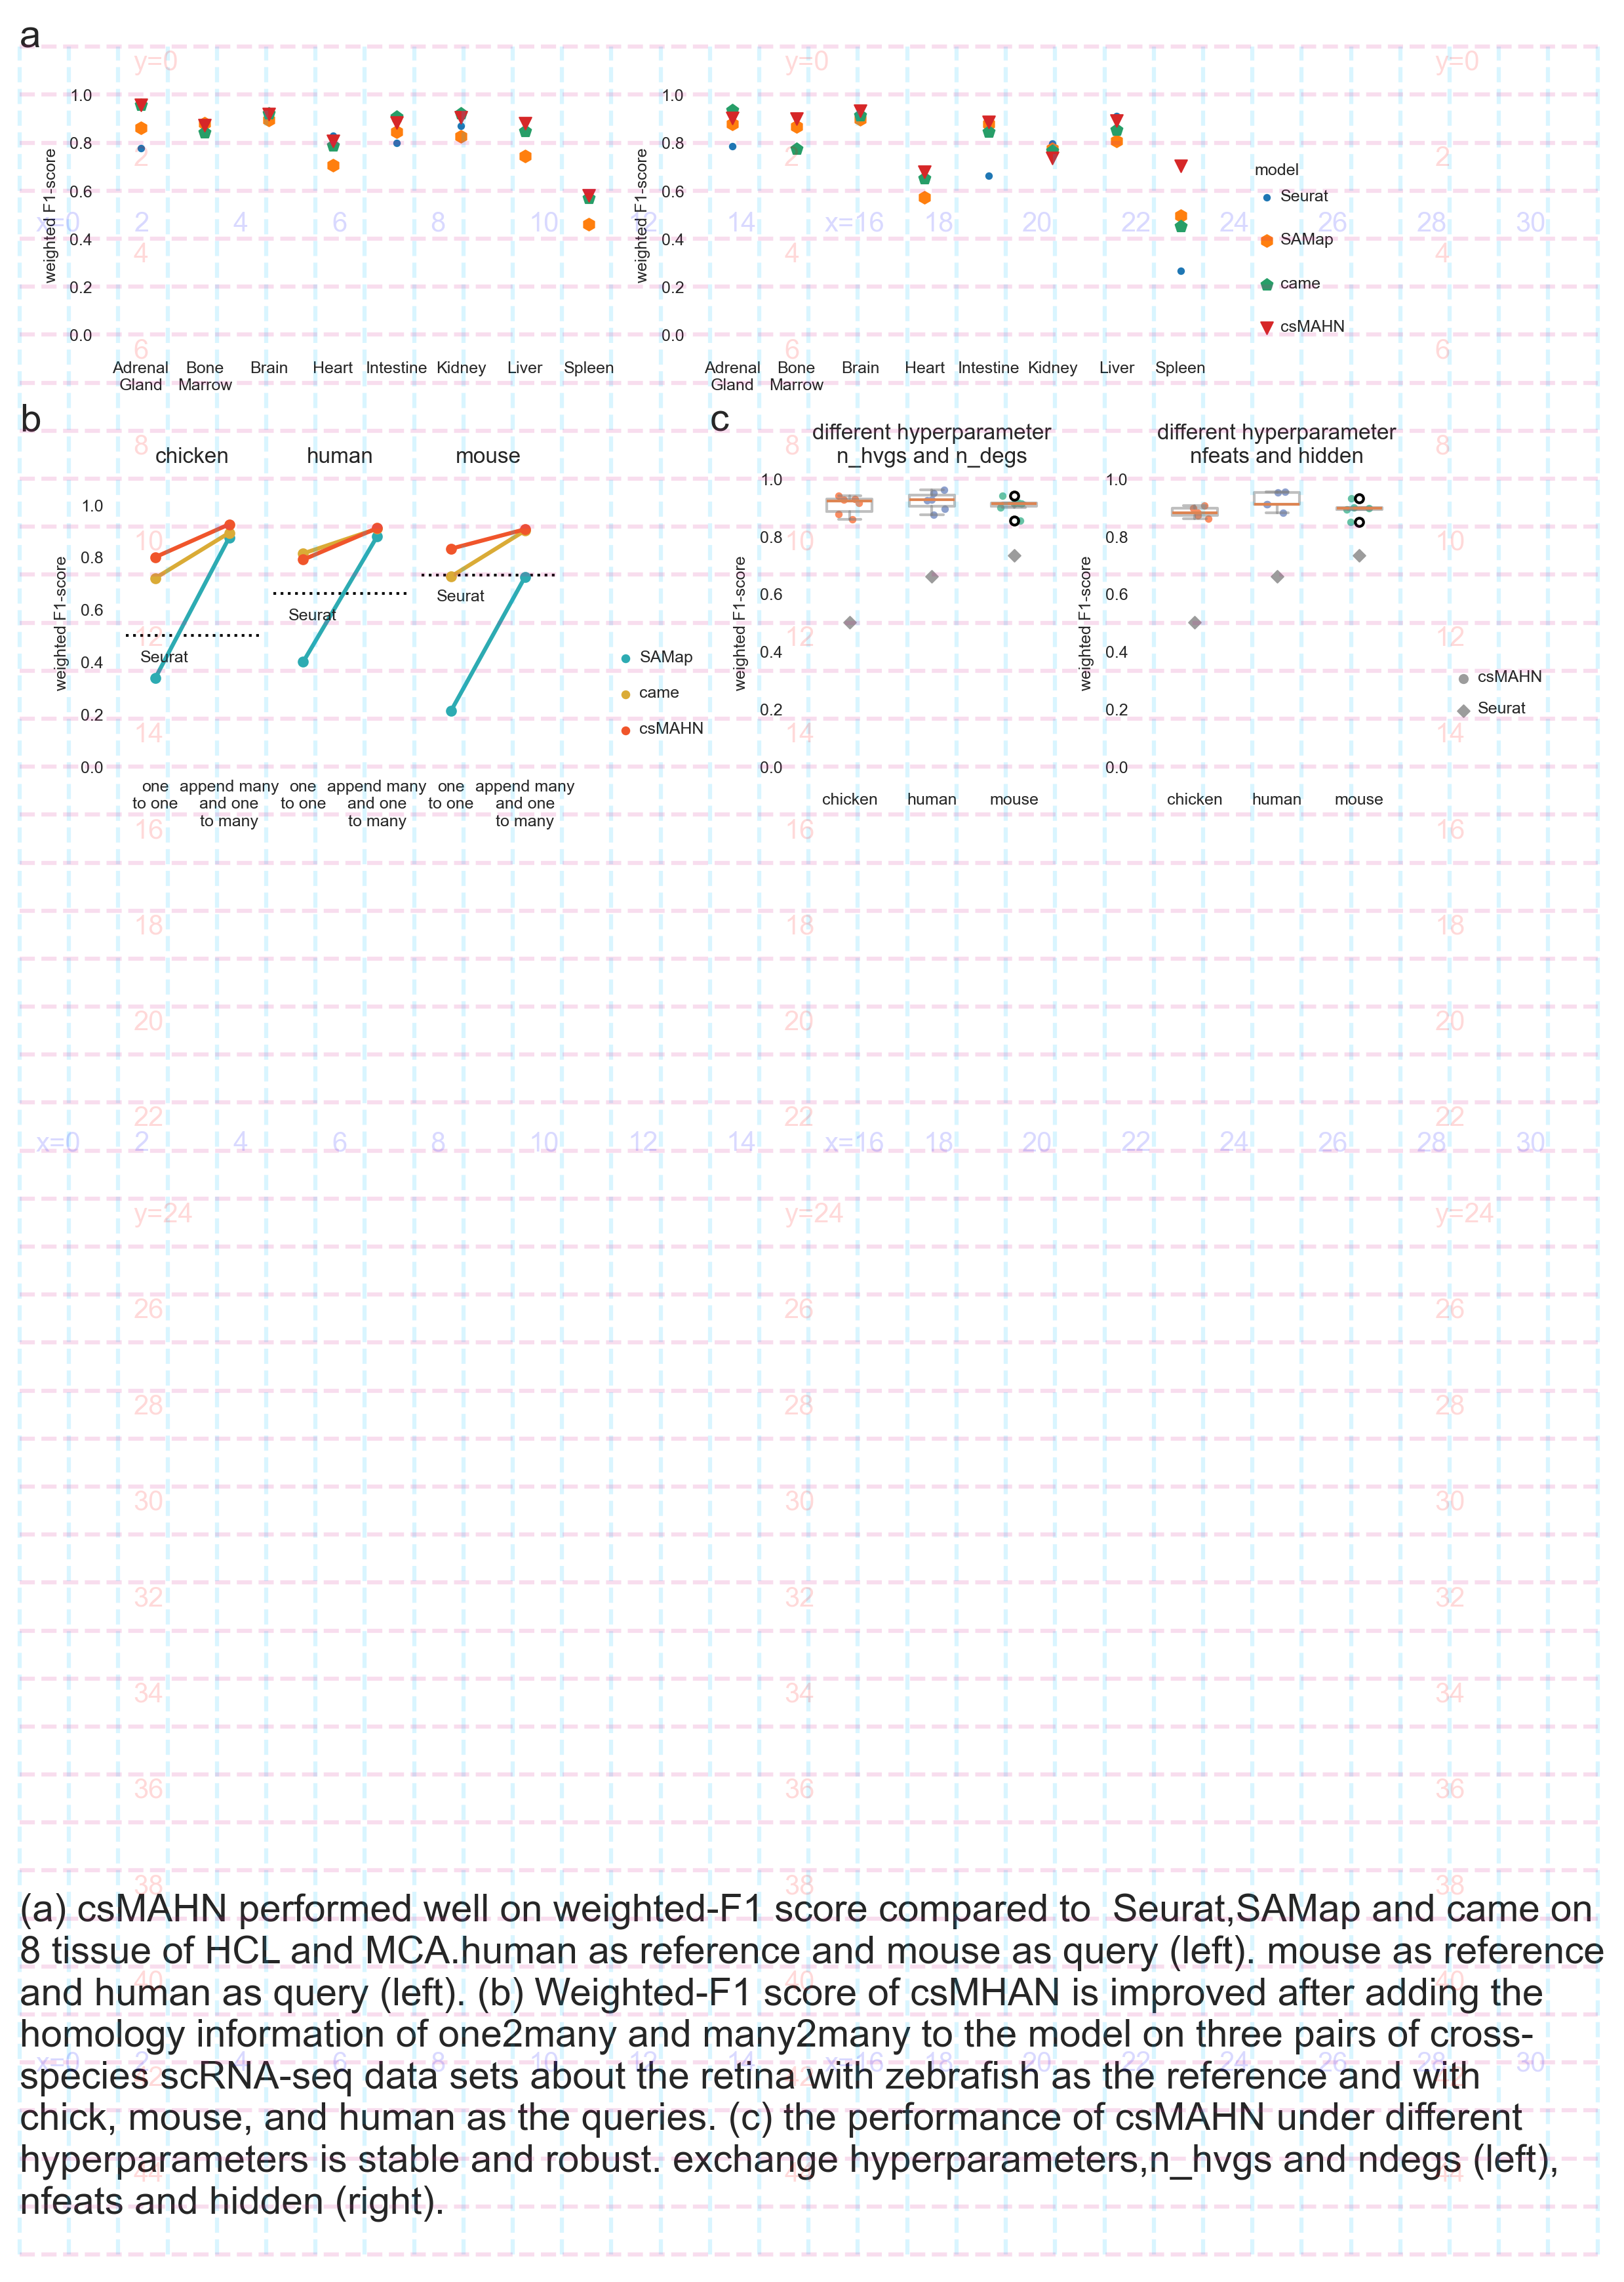

In [17]:
# fig.delaxes(ax)
# ax = plt_pdf_add_ax_with_spec(fig,spec,0,45,42)
display(fig)